## Initialisation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
FILE_NAME="Datasets/AirPassengers.csv"
SEP=","
HORIZON=4
FEATURE = "#Passengers"
XLABEL=""
YLABEL=""
TITLE=""

In [3]:
df=pd.read_csv(FILE_NAME, sep=SEP)

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df=df.dropna()

In [6]:
all_alpha = [0.1, 0.5, 0.9]

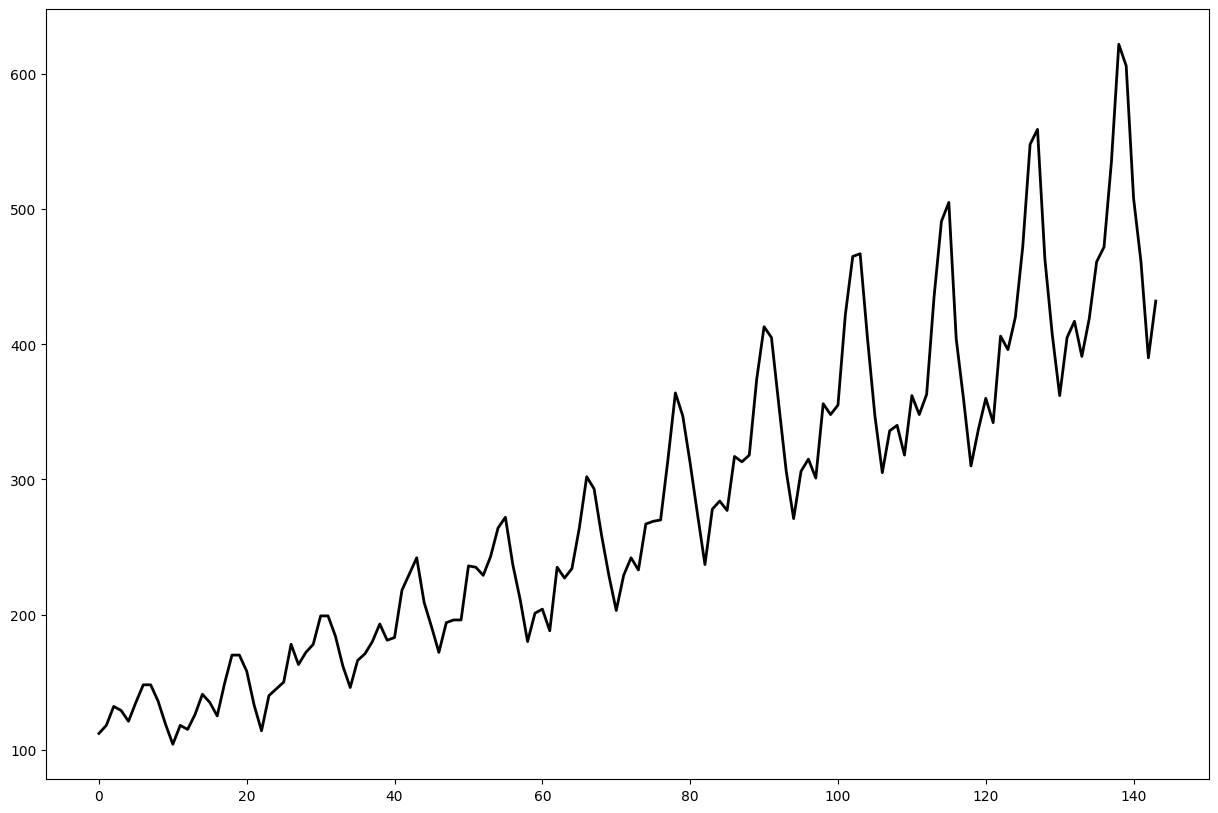

In [7]:
plt.figure(figsize=[15, 10])
plt.plot(df[FEATURE] , label='Donnees Reelles', c='black', lw=2)

## Lissage Simple

In [8]:
class Lissage_Simple:
    def __init__(self):
        self.L1=[]
    
    def __str__(self):
        return f"{self.L1}"
        
    def predict_simple_expo_lissage(self, data, alpha, taille):
        for i in range(taille):
            if i==0:
                self.L1.append((1-alpha)*data[i])
            else:
                tmp=(1-alpha)*data[i]+alpha*self.L1[i-1]
                self.L1.append(tmp)
        return self

In [9]:
all_L1={}
for alpha in all_alpha:
    L1=Lissage_Simple()
    all_L1[f"alpha_{alpha}"]=L1.predict_simple_expo_lissage(df[FEATURE], alpha, len(df[FEATURE])-HORIZON)

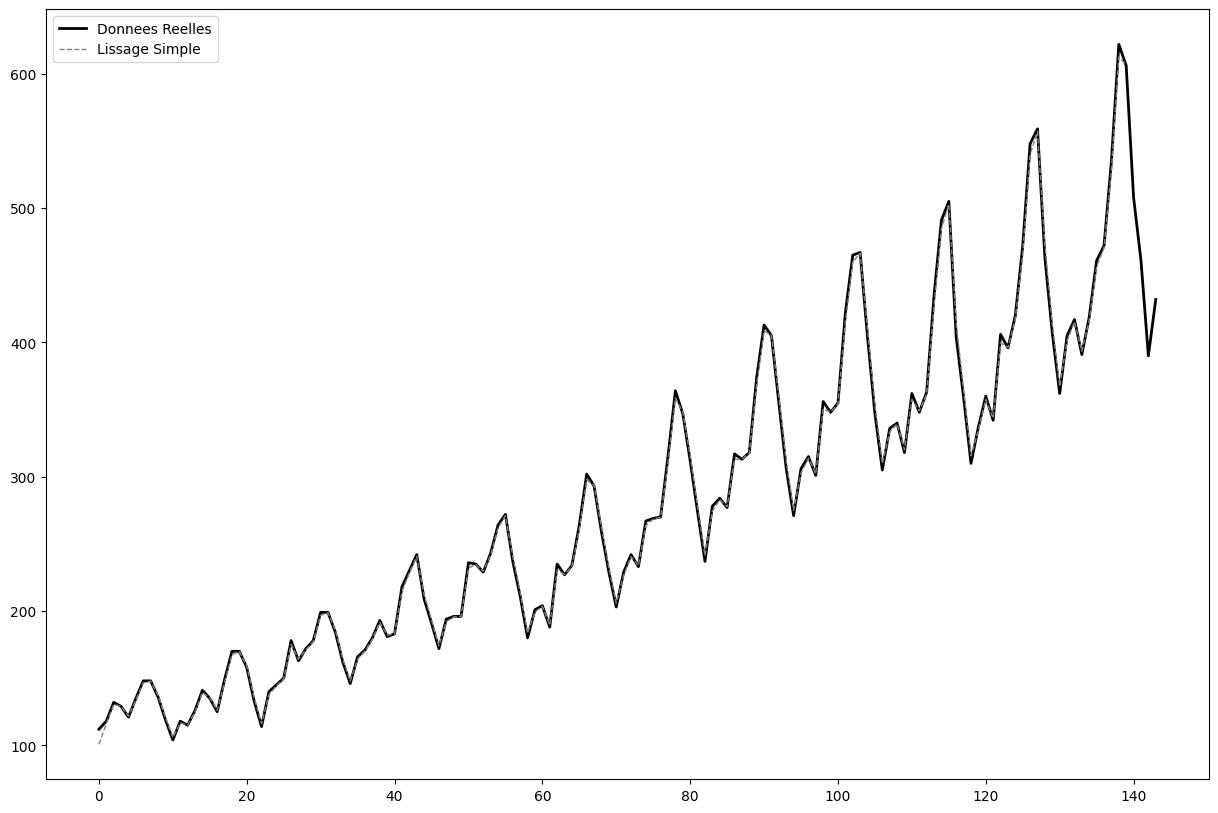

In [10]:
alpha = 0.1
plt.figure(figsize=[15, 10])
plt.plot(df[FEATURE] , label='Donnees Reelles', c='black', lw=2)
plt.plot(all_L1[f"alpha_{alpha}"].L1, label='Lissage Simple', c='grey', lw=1, ls='--')
plt.legend()

## Lissage Double

In [11]:
class Lissage_Double:
    def __init__(self):
        self.x_hat=[]
        self.a1=[]
        self.a2=[]
    
    def predict_lissage_double(self, data, alpha, length, horizon):
        for i in range(length-horizon):
            if i==0:
                self.a1.append(data[i])
                self.a2.append(data[i+1]-data[i])
            else :
                self.a1.append((alpha**2)*(self.a1[-1]+self.a2[-1])+(1-alpha**2)*(data[i]))
                self.a2.append(((1-alpha)**2)*(data[i])-((1-alpha)**2)*self.a1[-2]+(2*alpha-(alpha**2))*self.a2[-1])
            self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon)
        return self

In [12]:
all_LissDouble={}
for alpha in all_alpha:
    x_hat=Lissage_Double()
    all_LissDouble[f"alpha_{alpha}"]=x_hat.predict_lissage_double(df[FEATURE], alpha, len(df[FEATURE]), HORIZON)

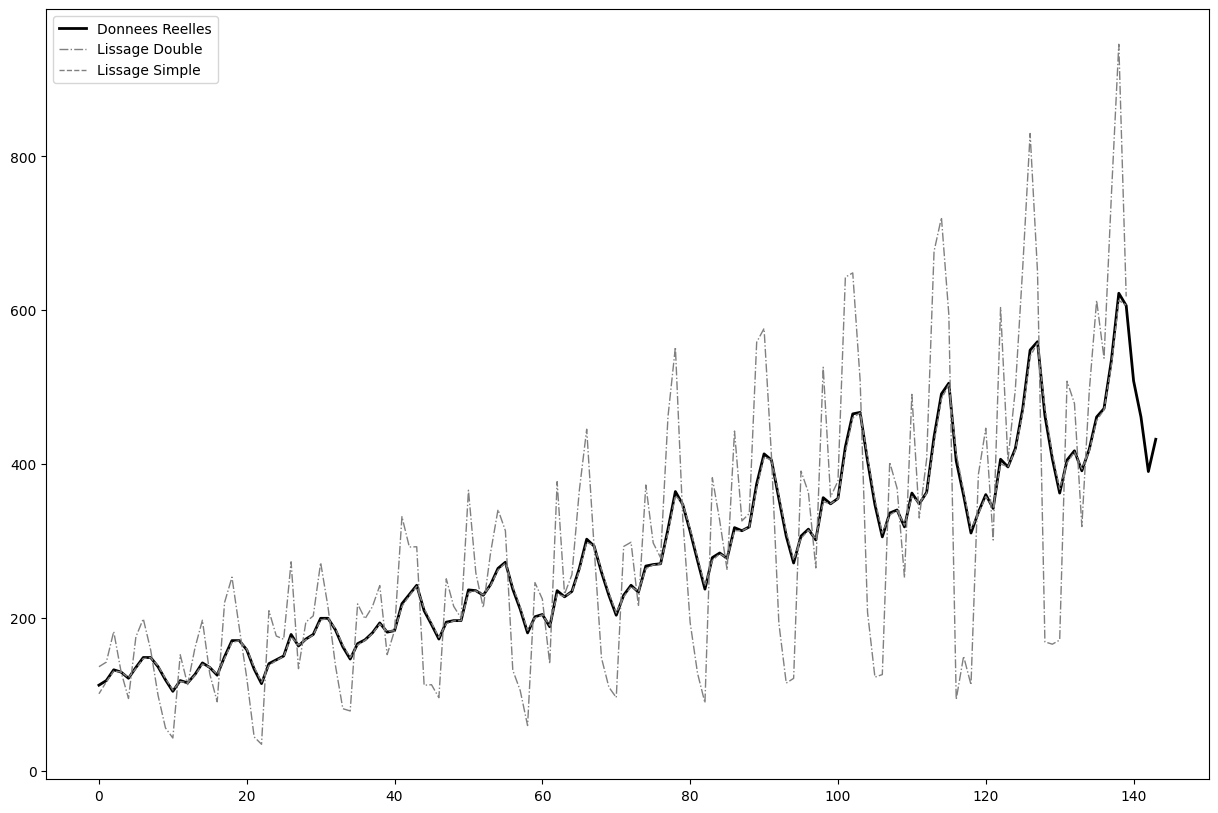

In [13]:
alpha = 0.1
plt.figure(figsize=[15, 10])
plt.plot(df[FEATURE] , label='Donnees Reelles', c='black', lw=2)
plt.plot(all_LissDouble[f"alpha_{alpha}"].x_hat , label='Lissage Double', ls='-.',c='grey', lw=1)
plt.plot(all_L1[f"alpha_{alpha}"].L1, label='Lissage Simple', c='grey', lw=1, ls='--')
plt.legend()

## Methode de Holt Winters

### Methode Non Saisonniere

In [14]:
class Lissage_HW_SS:
    def __init__(self):
        self.x_hat=[]
        self.a1=[]
        self.a2=[]
    
    def predict_lissage_hw_ss(self, data, beta, gamma, length, horizon):
        for i in range(length-horizon):
            if i==0:
                self.a1.append(data[i])
                self.a2.append(data[i+1]-data[i])
            else :
                self.a1.append(beta*data[i]+(1-beta)*(self.a1[-1]+self.a2[-1]))
                self.a2.append(gamma*(self.a1[-1]-self.a1[-2])+(1-gamma)*self.a2[-1])
            self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon)
        return self

In [15]:
holt_winters_ss={}
for beta in all_alpha:
    for gamma in all_alpha:
        key=f"{beta} {gamma}"
        hw_ss=Lissage_HW_SS()
        holt_winters_ss[key]=hw_ss.predict_lissage_hw_ss(df[FEATURE], beta, gamma, len(df[FEATURE]), HORIZON)

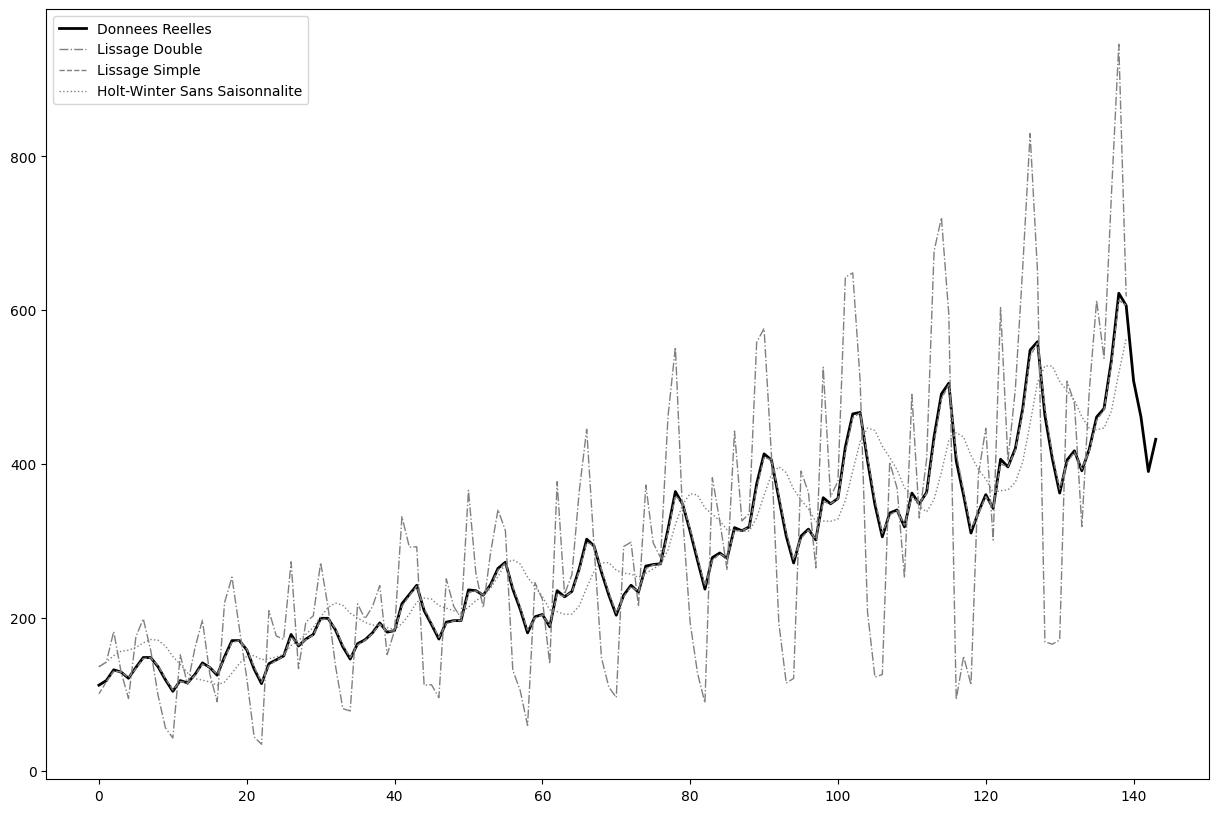

In [16]:
alpha = 0.1
beta=0.1
gamma=0.5
plt.figure(figsize=[15, 10])
plt.plot(df[FEATURE] , label='Donnees Reelles', c='black', ls='-', lw=2)
plt.plot(all_LissDouble[f"alpha_{alpha}"].x_hat , label='Lissage Double', ls='-.', c='grey', lw=1)
plt.plot(all_L1[f"alpha_{alpha}"].L1, label='Lissage Simple', c='grey', lw=1, ls='--')
plt.plot(holt_winters_ss[f"{beta} {gamma}"].x_hat, label='Holt-Winter Sans Saisonnalite', c='grey', lw=1, ls=':')
plt.legend()

### Methode Saisonniere Additive

In [17]:
class Lissage_HW_SA:
    def __init__(self, periode):
        self.x_hat=[]
        self.a1=[]
        self.a2=[]
        self.st=[]
        self.T=periode

    def initialize(self, data, horizon):
        self.a1.append(np.mean(data[:self.T]))
        tmp1=np.array(data[:self.T])
        tmp2=np.array(data[self.T:2*self.T])
        self.a2.append(np.mean((tmp2-tmp1)/self.T))
        for i in range(self.T):
            self.st.append(data[i]-self.a1[0])
        self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[0])
    
    def predict_lissage_hw_sa(self, data, beta, gamma, omega,length, horizon):
        self.initialize(data, horizon)
        for i in range(1, length-horizon):
            if i < self.T:
                self.a1.append(beta*(data[i]-self.st[i])+(1-beta)*(self.a1[-1]+self.a2[-1]))
                self.a2.append(gamma*(self.a1[-1]-self.a1[-2])+(1-gamma)*self.a2[-1])
                if horizon < self.T:
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-self.T])
                else :
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-2*self.T])
            else:
                self.a1.append(beta*(data[i]-self.st[i-self.T])+(1-beta)*(self.a1[-1]+self.a2[-1]))
                self.a2.append(gamma*(self.a1[-1]-self.a1[-2])+(1-gamma)*self.a2[-1])
                self.st.append(omega*(data[i]-self.a1[-1])+(1-omega)*self.st[i-self.T])
                if horizon < self.T:
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-self.T])
                else :
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-2*self.T])
        return self

In [18]:
def season_check(periode):
    for i in range(periode,len(df[FEATURE]),periode):
        x=np.linspace(0,periode-1,periode)
        if i==0:
            plt.plot(x,df[FEATURE][:periode])
        else:
            plt.plot(x,df[FEATURE][i-periode:i])

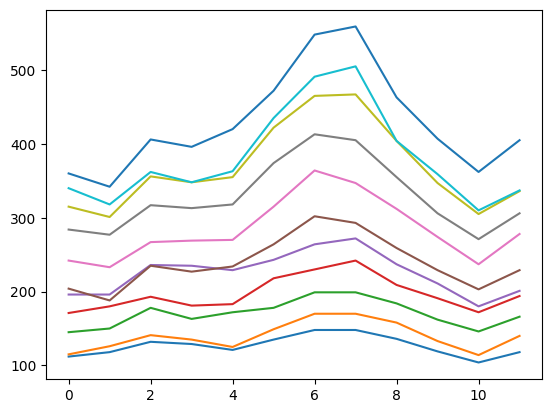

In [19]:
periode = 12
season_check(periode)

In [20]:
holt_winters_sa={}
for beta in all_alpha:
    for gamma in all_alpha:
        for omega in all_alpha:
            key=f"{beta} {gamma} {omega}"
            hw_ss=Lissage_HW_SA(periode)
            holt_winters_sa[key]=hw_ss.predict_lissage_hw_sa(df[FEATURE], beta, gamma, omega, len(df[FEATURE]), HORIZON)

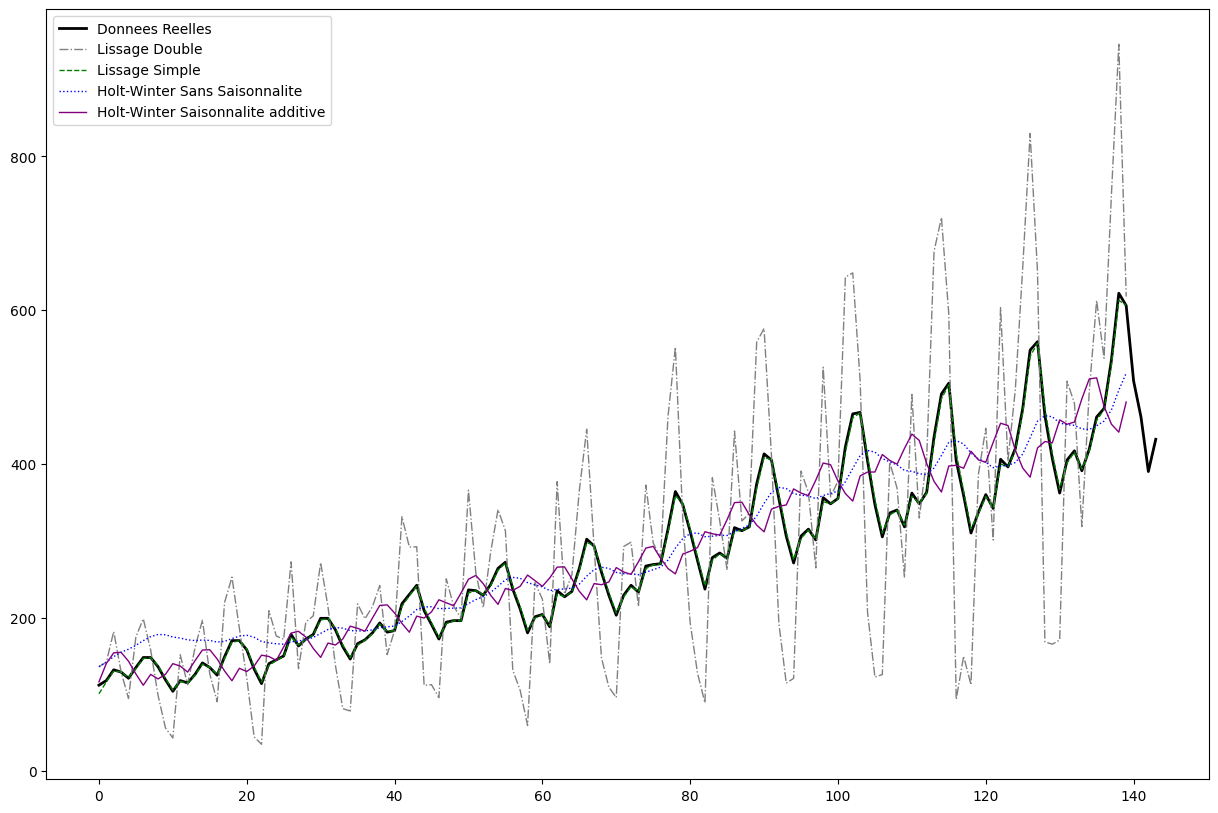

In [21]:
alpha = 0.1
beta=0.1
gamma=0.1
omega=0.1
plt.figure(figsize=[15, 10])
plt.plot(df[FEATURE] , label='Donnees Reelles', c='black', ls='-', lw=2)
plt.plot(all_LissDouble[f"alpha_{alpha}"].x_hat , label='Lissage Double', ls='-.', c='grey', lw=1)
plt.plot(all_L1[f"alpha_{alpha}"].L1, label='Lissage Simple', c='green', lw=1, ls='--')
plt.plot(holt_winters_ss[f"{beta} {gamma}"].x_hat, label='Holt-Winter Sans Saisonnalite', c='blue', lw=1, ls=':')
plt.plot(holt_winters_sa[f"{beta} {gamma} {omega}"].x_hat, label='Holt-Winter Saisonnalite additive', c='purple', lw=1, ls='-')
plt.legend()

### Methode Saisonniere Multiplicative

In [22]:
class Lissage_HW_SM:
    def __init__(self, periode):
        self.x_hat=[]
        self.a1=[]
        self.a2=[]
        self.st=[]
        self.T=periode

    def initialize(self, data, horizon):
        self.a1.append(np.mean(data[:self.T]))
        tmp1=np.array(data[:self.T])
        tmp2=np.array(data[self.T:2*self.T])
        self.a2.append(np.mean((tmp2-tmp1)/self.T))
        for i in range(self.T):
            self.st.append(data[i]/self.a1[0])
        self.x_hat.append((self.a1[0]+self.a2[0]*horizon)*self.st[0])
    
    def predict_lissage_hw_sa(self, data, beta, gamma, omega,length, horizon):
        self.initialize(data, horizon)
        for i in range(1, length-horizon):
            if i < self.T:
                self.a1.append(beta*(data[i]/self.st[i])+(1-beta)*(self.a1[-1]+self.a2[-1]))
                self.a2.append(gamma*(self.a1[-1]-self.a1[-2])+(1-gamma)*self.a2[-1])
                if horizon < self.T:
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-self.T])
                else :
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-2*self.T])
            else:
                self.a1.append(beta*(data[i]/self.st[i-self.T])+(1-beta)*(self.a1[-1]+self.a2[-1]))
                self.a2.append(gamma*(self.a1[-1]-self.a1[-2])+(1-gamma)*self.a2[-1])
                self.st.append(omega*(data[i]/self.a1[-1])+(1-omega)*self.st[i-self.T])
                if horizon < self.T:
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-self.T])
                else :
                    self.x_hat.append(self.a1[-1]+self.a2[-1]*horizon+self.st[i+horizon-2*self.T])
        return self

In [23]:
holt_winters_sm={}
for beta in all_alpha:
    for gamma in all_alpha:
        for omega in all_alpha:
            key=f"{beta} {gamma} {omega}"
            hw_ss=Lissage_HW_SM(periode)
            holt_winters_sm[key]=hw_ss.predict_lissage_hw_sa(df[FEATURE], beta, gamma, omega, len(df[FEATURE]), HORIZON)

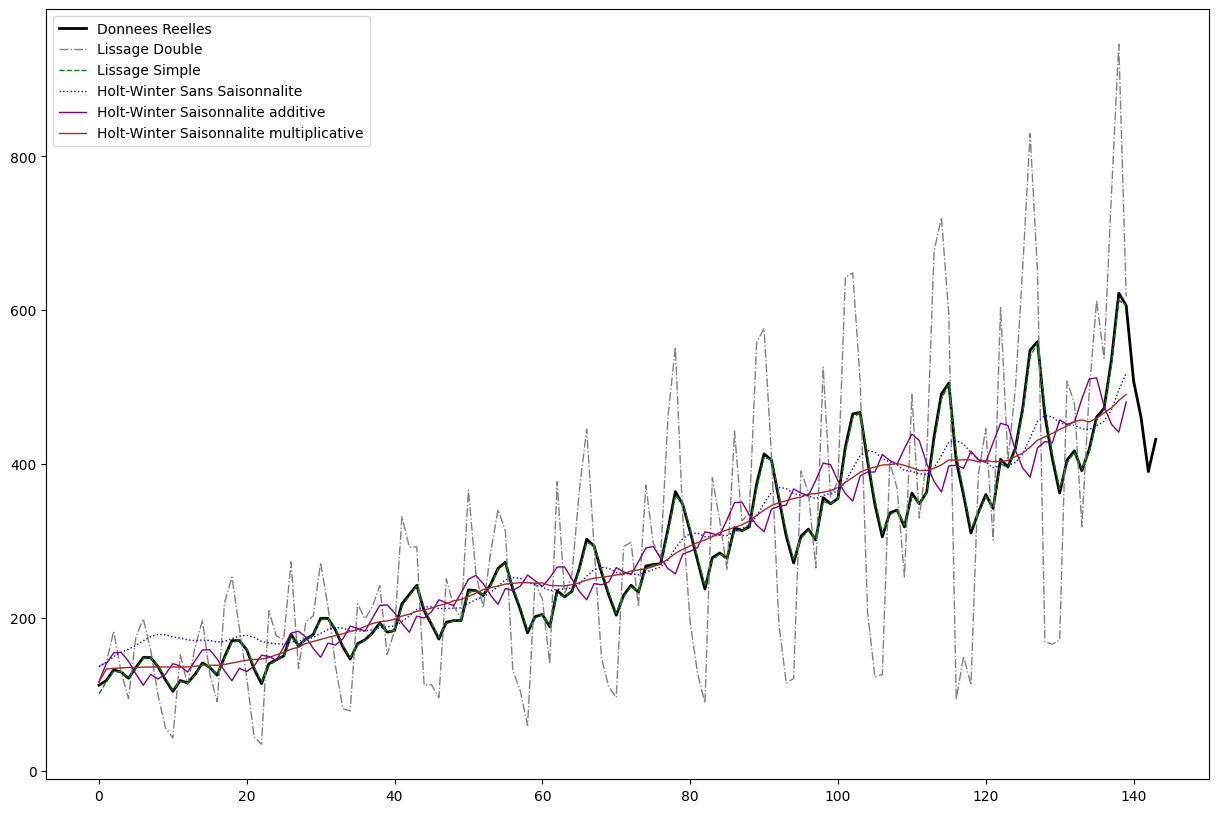

In [24]:
alpha = 0.1
beta=0.1
gamma=0.1
omega=0.1
plt.figure(figsize=[15, 10])
plt.plot(df[FEATURE] , label='Donnees Reelles', c='black', ls='-', lw=2)
plt.plot(all_LissDouble[f"alpha_{alpha}"].x_hat , label='Lissage Double', ls='-.', c='grey', lw=1)
plt.plot(all_L1[f"alpha_{alpha}"].L1, label='Lissage Simple', c='green', lw=1, ls='--')
plt.plot(holt_winters_ss[f"{beta} {gamma}"].x_hat, label='Holt-Winter Sans Saisonnalite', c='blue', lw=1, ls=':')
plt.plot(holt_winters_sa[f"{beta} {gamma} {omega}"].x_hat, label='Holt-Winter Saisonnalite additive', c='purple', lw=1, ls='-')
plt.plot(holt_winters_sm[f"{beta} {gamma} {omega}"].x_hat, label='Holt-Winter Saisonnalite multiplicative', c='brown', lw=1, ls='-')
plt.legend()

## Erreur des modeles

### Lissage Simple

In [25]:
def sum_square_error(real, predic):
    result=real-predic
    result=result**2
    return np.sum(result)

In [26]:
all_error_L1={}
for alpha in all_alpha:
    real=np.array(df[FEATURE])
    predic=np.array(all_L1[f"alpha_{alpha}"].L1)
    all_error_L1[f"alpha_{alpha}"]=sum_square_error(real[:real.shape[0]-HORIZON], predic)

### Lissage Double

In [27]:
all_error_LissDouble={}
for alpha in all_alpha:
    real=np.array(df[FEATURE])
    predic=np.array(all_LissDouble[f"alpha_{alpha}"].x_hat)
    all_error_LissDouble[f"alpha_{alpha}"]=sum_square_error(real[:real.shape[0]-HORIZON], predic)

### Holt Winter sans saisonnalite

In [28]:
holt_error_winters_ss={}
for beta in all_alpha:
    for gamma in all_alpha:
        real=np.array(df[FEATURE])
        predic=np.array(holt_winters_ss[f"{beta} {gamma}"].x_hat)
        holt_error_winters_ss[f"{beta} {gamma}"]=sum_square_error(real[:real.shape[0]-HORIZON], predic)

### Holt Winter saisonnalite additive

In [29]:
holt_error_winters_sa={}
for beta in all_alpha:
    for gamma in all_alpha:
        for omega in all_alpha:
            real=np.array(df[FEATURE])
            predic=np.array(holt_winters_sa[f"{beta} {gamma} {omega}"].x_hat)
            holt_error_winters_sa[f"{beta} {gamma} {omega}"]=sum_square_error(real[:real.shape[0]-HORIZON], predic)

### Holt Winter saisonnalite multiplicative

In [30]:
holt_error_winters_sm={}
for beta in all_alpha:
    for gamma in all_alpha:
        for omega in all_alpha:
            real=np.array(df[FEATURE])
            predic=np.array(holt_winters_sm[f"{beta} {gamma} {omega}"].x_hat)
            holt_error_winters_sm[f"{beta} {gamma} {omega}"]=sum_square_error(real[:real.shape[0]-HORIZON], predic)